# Predictive Maintenance

## Importing necessary libraries

In [65]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, max_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

import xgboost as xgb

# Combining Data

In [18]:
# Filepath to read data
dir_path = 'Data/'

# define column names for easy indexing
index_names = ['device_id', 'cycle']
setting_names = ['op_cond_1', 'op_cond_2', 'op_cond_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train_1 = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test_1 = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test_1 = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

train_2 = pd.read_csv((dir_path+'train_FD002.txt'), sep='\s+', header=None, names=col_names)
test_2 = pd.read_csv((dir_path+'test_FD002.txt'), sep='\s+', header=None, names=col_names)
y_test_2 = pd.read_csv((dir_path+'RUL_FD002.txt'), sep='\s+', header=None, names=['RUL'])

train_1.head()

,device_id,cycle,op_cond_1,op_cond_2,op_cond_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [19]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   device_id  20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   op_cond_1  20631 non-null  float64
 3   op_cond_2  20631 non-null  float64
 4   op_cond_3  20631 non-null  float64
 5   s_1        20631 non-null  float64
 6   s_2        20631 non-null  float64
 7   s_3        20631 non-null  float64
 8   s_4        20631 non-null  float64
 9   s_5        20631 non-null  float64
 10  s_6        20631 non-null  float64
 11  s_7        20631 non-null  float64
 12  s_8        20631 non-null  float64
 13  s_9        20631 non-null  float64
 14  s_10       20631 non-null  float64
 15  s_11       20631 non-null  float64
 16  s_12       20631 non-null  float64
 17  s_13       20631 non-null  float64
 18  s_14       20631 non-null  float64
 19  s_15       20631 non-null  float64
 20  s_16  

In [20]:
print('Train set: ', train_1.shape)
print('Test set: ', test_1.shape)

Train set:  (20631, 26)
Test set:  (13096, 26)


In [21]:
print('Train set: ', train_2.shape)
print('Test set: ', test_2.shape)

Train set:  (53759, 26)
Test set:  (33991, 26)


> Generating RUL for train set

In [22]:
train_1['RUL'] = train_1.groupby('device_id')['cycle'].transform(max) - train_1['cycle']
train_2['RUL'] = train_2.groupby('device_id')['cycle'].transform(max) - train_2['cycle']

In [23]:
train_max_id = train_1['device_id'].unique().max()
train_max_id

100

In [24]:
train_2['device_id'] = train_2['device_id'] + train_max_id
train_2.head(10)

,device_id,cycle,op_cond_1,op_cond_2,op_cond_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,101,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,101,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,101,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,101,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,101,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144
5,101,6,25.0045,0.6205,60.0,462.54,537.02,1266.38,1048.72,7.05,...,2028.01,7868.87,10.8912,0.02,306,1915,84.93,14.28,8.5590,143
6,101,7,42.0043,0.8409,100.0,445.00,549.74,1347.45,1127.19,3.91,...,2387.69,8075.54,9.3753,0.02,330,2212,100.00,10.62,6.4227,142
7,101,8,20.0020,0.7002,100.0,491.19,607.44,1481.69,1252.36,9.35,...,2387.99,8049.26,9.2369,0.02,365,2324,100.00,24.33,14.7989,141
8,101,9,41.9995,0.8407,100.0,445.00,549.33,1348.23,1127.45,3.91,...,2387.62,8065.78,9.3878,0.02,331,2212,100.00,10.69,6.3802,140
9,101,10,42.0011,0.8400,100.0,445.00,549.33,1356.40,1127.11,3.91,...,2387.62,8069.11,9.3957,0.02,329,2212,100.00,10.57,6.2847,139


In [25]:
train = pd.concat([train_1, train_2])
train.head()

,device_id,cycle,op_cond_1,op_cond_2,op_cond_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [26]:
train.shape

(74390, 27)

#### Test Set

In [27]:
y_test_1['device_id'] = y_test_1.index + 1
y_test_2['device_id'] = y_test_2.index + 1

> Generating RUL for test set

In [28]:
y_test_1['RUL'] = y_test_1['RUL'] + test_1.groupby('device_id')['cycle'].max().values
y_test_2['RUL'] = y_test_2['RUL'] + test_2.groupby('device_id')['cycle'].max().values

In [29]:
test_1 = test_1.merge(y_test_1, on=['device_id'], how='left')
test_1['RUL'] = test_1['RUL'] - test_1['cycle']
test_1

,device_id,cycle,op_cond_1,op_cond_2,op_cond_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [30]:
test_2 = test_2.merge(y_test_2, on=['device_id'], how='left')
test_2['RUL'] = test_2['RUL'] - test_2['cycle']
test_2

,device_id,cycle,op_cond_1,op_cond_2,op_cond_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,35.0015,0.8403,100.0,449.44,555.56,1366.01,1129.47,5.48,...,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065,55
33987,259,120,42.0066,0.8405,100.0,445.00,549.42,1351.13,1123.86,3.91,...,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075,54
33988,259,121,42.0061,0.8400,100.0,445.00,549.65,1349.14,1118.91,3.91,...,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805,53
33989,259,122,0.0024,0.0003,100.0,518.67,642.58,1589.61,1408.16,14.62,...,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589,52


In [31]:
test_max_id = test_1['device_id'].unique().max()
test_max_id

100

In [32]:
test_2['device_id'] = test_2['device_id'] + test_max_id
test_2.head()

,device_id,cycle,op_cond_1,op_cond_2,op_cond_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,101,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,101,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,101,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,101,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,101,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271


In [33]:
test = pd.concat([test_1, test_2])
test.head()

,device_id,cycle,op_cond_1,op_cond_2,op_cond_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [34]:
print('Train set: ', train.shape)
print('Test set: ', test.shape)

Train set:  (74390, 27)
Test set:  (47087, 27)


##### Checking for null values

In [35]:
train.isnull().sum()

device_id    0
cycle        0
op_cond_1    0
op_cond_2    0
op_cond_3    0
s_1          0
s_2          0
s_3          0
s_4          0
s_5          0
s_6          0
s_7          0
s_8          0
s_9          0
s_10         0
s_11         0
s_12         0
s_13         0
s_14         0
s_15         0
s_16         0
s_17         0
s_18         0
s_19         0
s_20         0
s_21         0
RUL          0
dtype: int64

In [36]:
test.isnull().sum()

device_id    0
cycle        0
op_cond_1    0
op_cond_2    0
op_cond_3    0
s_1          0
s_2          0
s_3          0
s_4          0
s_5          0
s_6          0
s_7          0
s_8          0
s_9          0
s_10         0
s_11         0
s_12         0
s_13         0
s_14         0
s_15         0
s_16         0
s_17         0
s_18         0
s_19         0
s_20         0
s_21         0
RUL          0
dtype: int64

In [37]:
train[index_names].groupby('device_id').max().describe().T

,count,mean,std,min,25%,50%,75%,max
cycle,360.0,206.638889,46.596503,128.0,174.0,199.0,230.0,378.0


In [38]:
train[setting_names + sensor_names].describe().T

,count,mean,std,min,25%,50%,75%,max
op_cond_1,74390.0,17.342791,16.510497,-0.0087,0.0013,19.99855,35.0017,42.0080
op_cond_2,74390.0,0.413405,0.367481,-0.0006,0.0002,0.62000,0.8400,0.8420
op_cond_3,74390.0,95.697271,12.393456,60.0000,100.0000,100.00000,100.0000,100.0000
s_1,74390.0,485.601030,30.380108,445.0000,449.4400,489.05000,518.6700,518.6700
s_2,74390.0,597.146913,42.433760,535.5300,550.0500,605.76000,642.4600,644.5300
s_3,74390.0,1467.271195,118.118320,1243.7300,1358.1300,1493.25000,1587.8500,1616.9100
s_4,74390.0,1261.877546,136.296038,1023.7700,1128.2900,1267.30500,1404.7300,1441.4900
s_5,74390.0,9.859077,4.258707,3.9100,5.4800,9.35000,14.6200,14.6200
s_6,74390.0,14.376614,6.434312,5.7100,8.0000,13.66000,21.6100,21.6100
s_7,74390.0,357.698447,173.490340,136.8000,175.5900,335.42000,553.0900,556.0600


### Visualization

#### Correlation Matrix

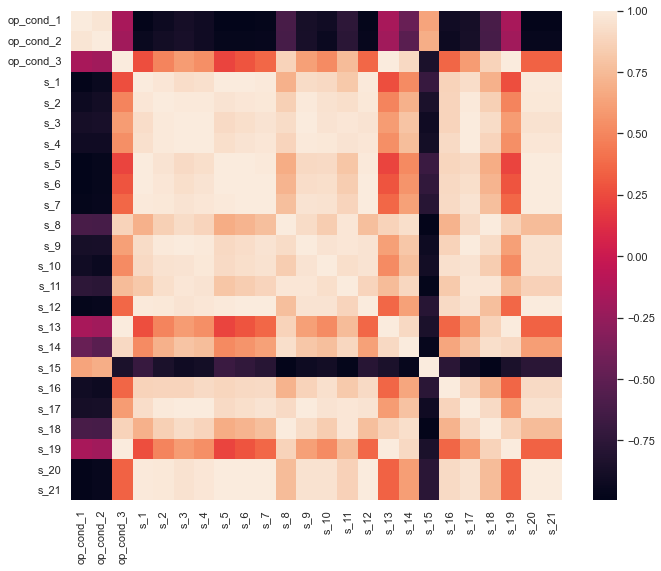

In [39]:
corr_all = train.drop(['device_id', 'cycle', 'RUL'], axis=1).corr()
sns.set(style="white")
figure_size=(11,9)
f, ax = plt.subplots(figsize=figure_size)
sns.heatmap(corr_all)
plt.show()

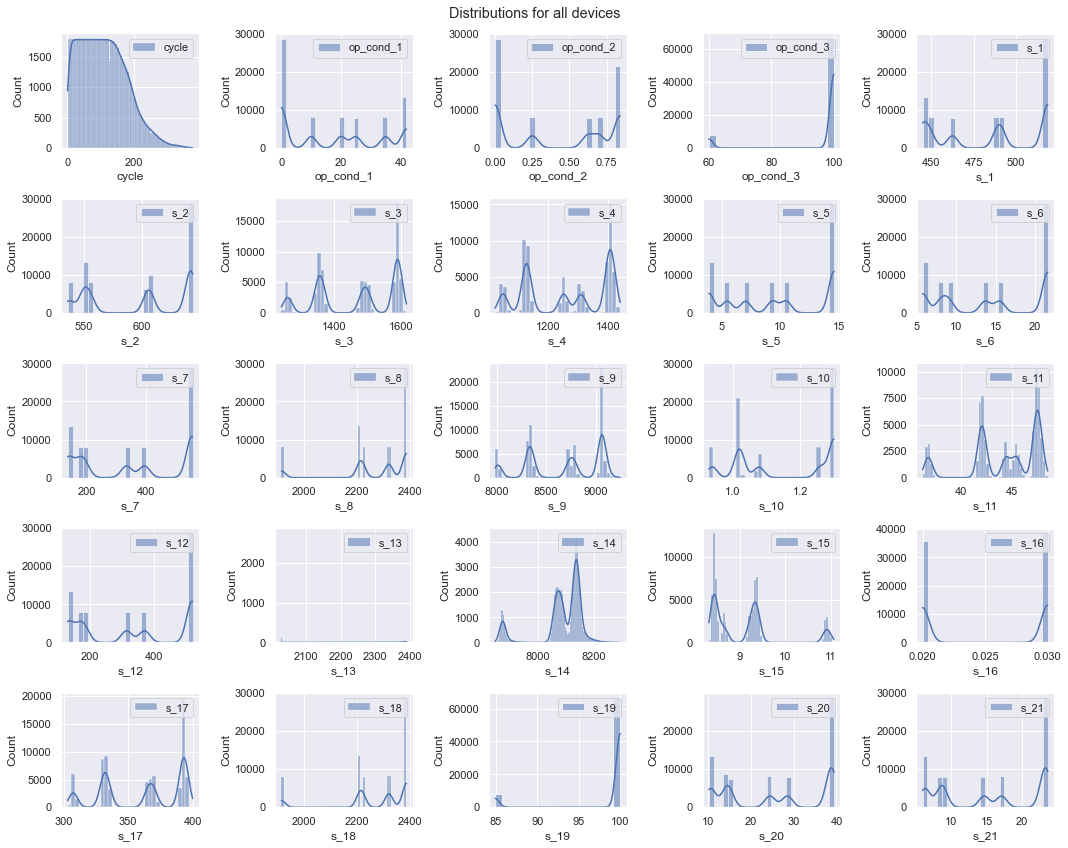

In [40]:
cols = train.drop(['device_id', 'RUL'], axis=1).columns
n_cols = min(len(cols), 5)
n_rows = int(np.ceil(len(cols) / n_cols))

sns.set()
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,12))
axes = axes.flatten()
fig.suptitle('Distributions for all devices')
df_plot = train.drop(['device_id', 'RUL'], axis=1)
for col, ax in zip(cols, axes):
    ax=sns.histplot(df_plot[col], ax=ax, label=col, kde=True)
    ax.legend(loc=1)

fig.tight_layout()
plt.show()

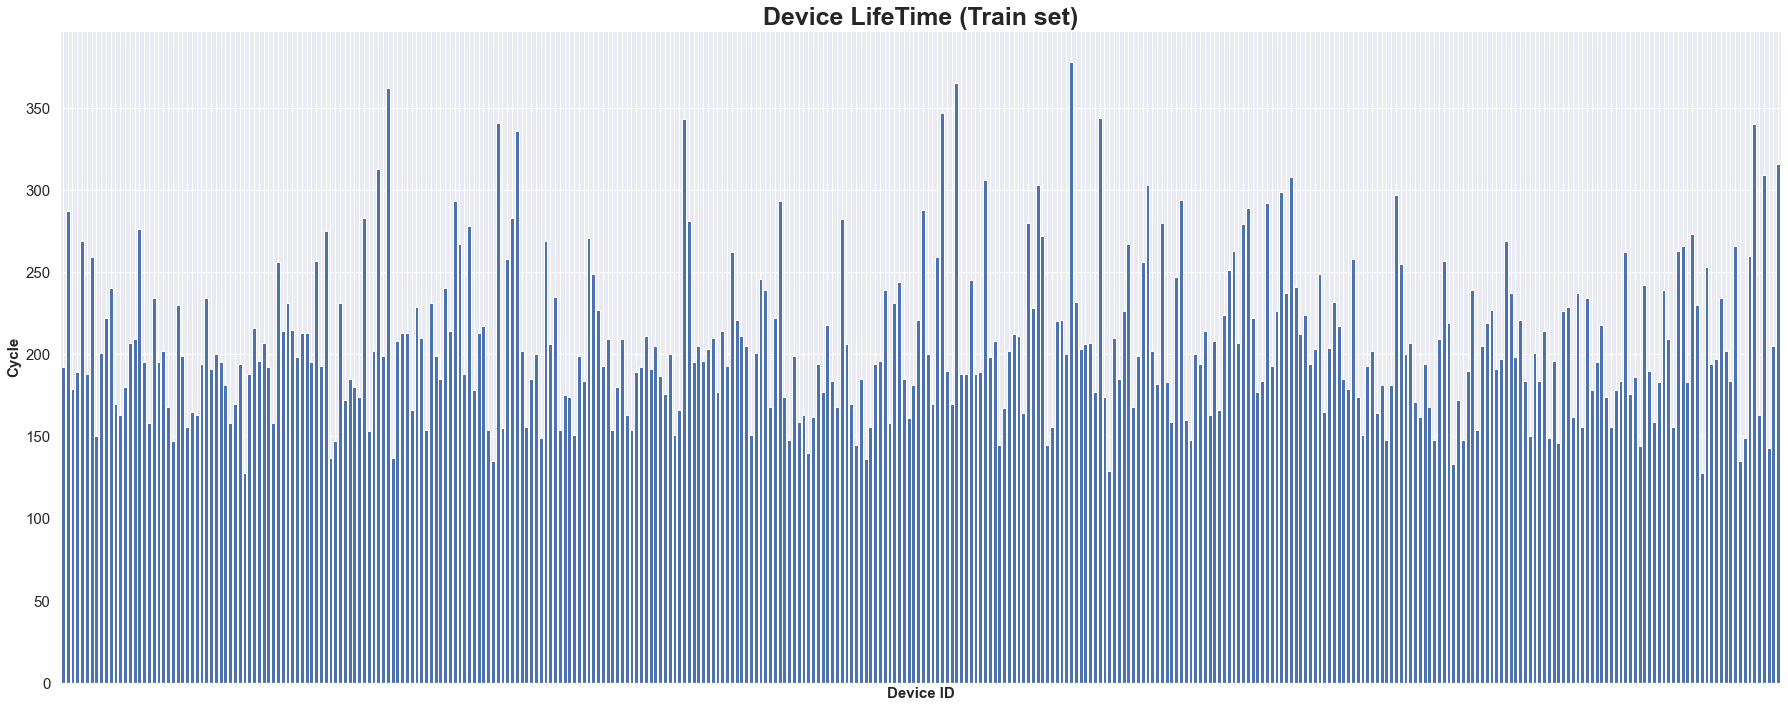

In [41]:
plt.figure(figsize=(25,10))
ax = train.groupby('device_id')['cycle'].max().plot(kind='bar',width=0.8, stacked=True,align='center',rot=90)
plt.title('Device LifeTime (Train set)',fontweight='bold',size=25)
plt.xlabel('Device ID',fontweight='bold',size=15)
# plt.xticks(size=15)
plt.ylabel('Cycle',fontweight='bold',size=15)
plt.yticks(size=15)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.tight_layout()
plt.show()

In [44]:
drop_sensors = ['s_1','s_5','s_10','s_16','s_18','s_19']
drop_labels = index_names + setting_names+ drop_sensors + ['RUL']

X_train = train.drop(drop_labels, axis=1)
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

X_test = test.drop(drop_labels, axis=1)
y_test = test['RUL'].copy()
y_test_clipped = y_test.clip(upper=125)

In [45]:
X_train.head()

,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [46]:
X_test.head()

,s_2,s_3,s_4,s_6,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130


In [47]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
def plot_signal(df, signal_name, device_id=None):
    plt.figure(figsize=(19,5))
    if device_id:
        plt.plot('RUL', signal_name, data=df[df['device_id']==device_id])
    plt.xlim(250, 0)
    plt.xticks(np.arange(0, 225, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

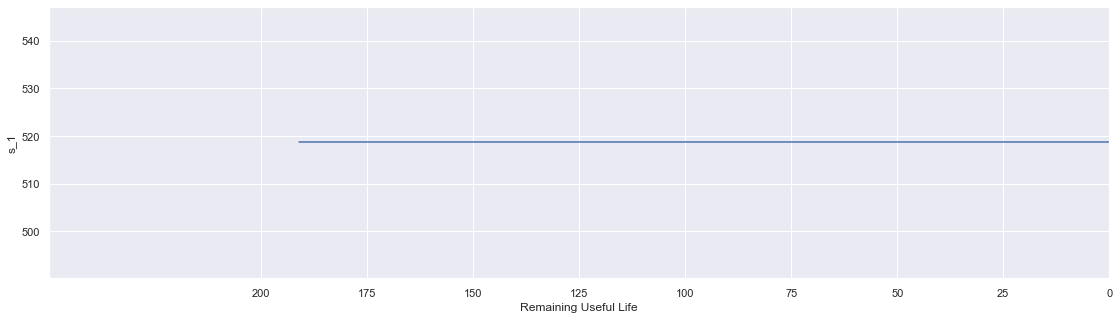

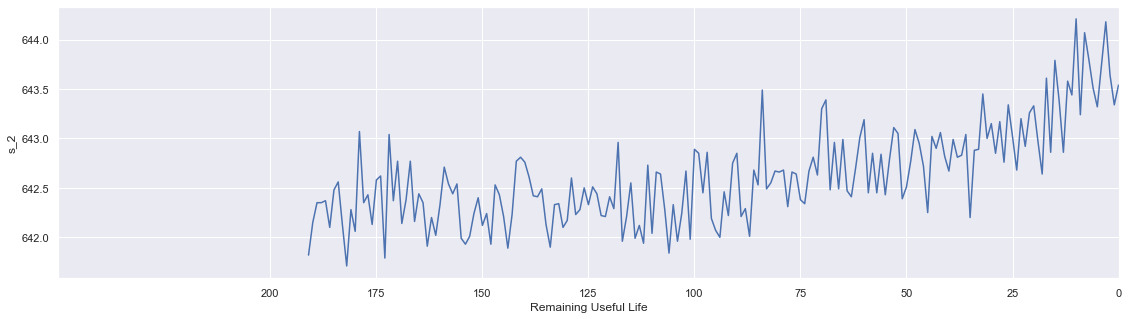

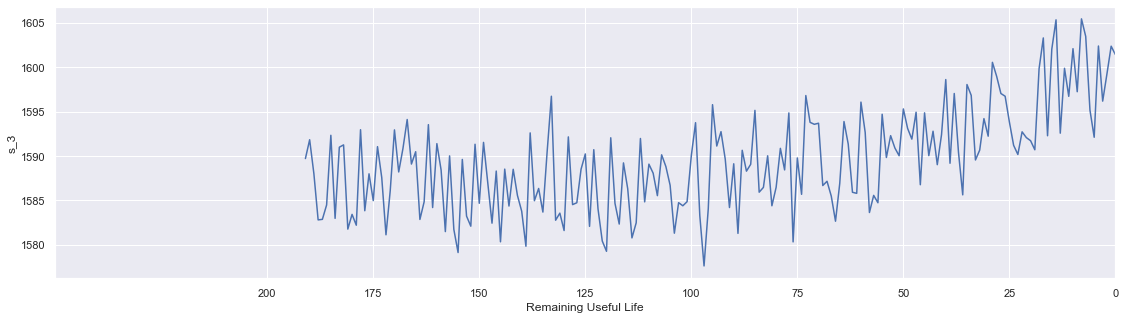

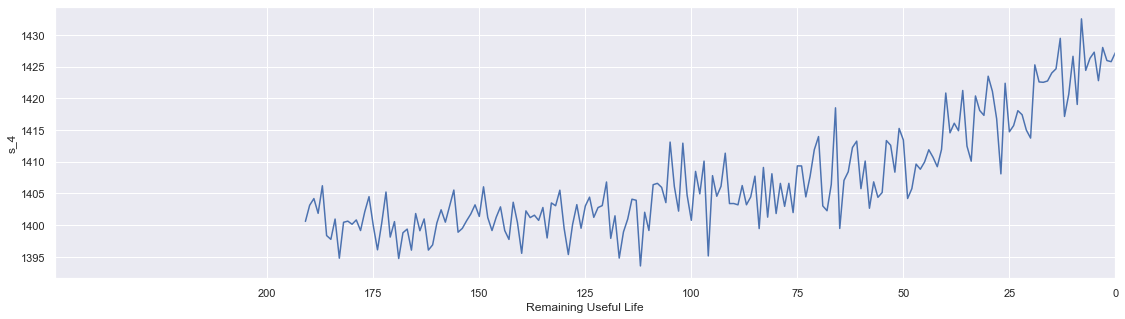

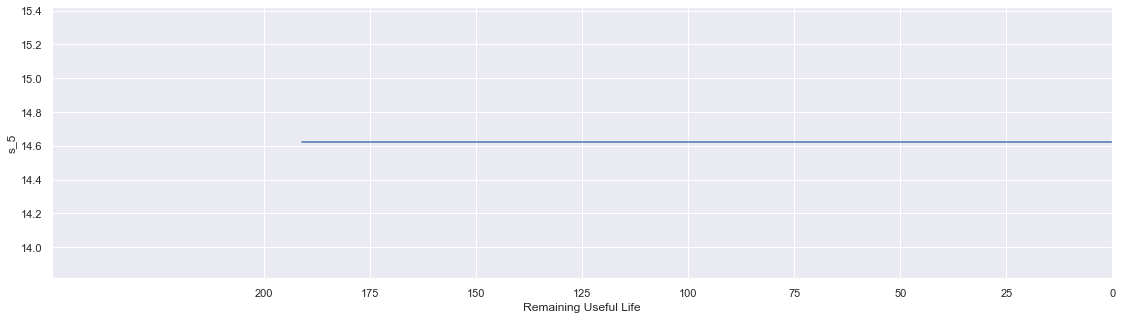

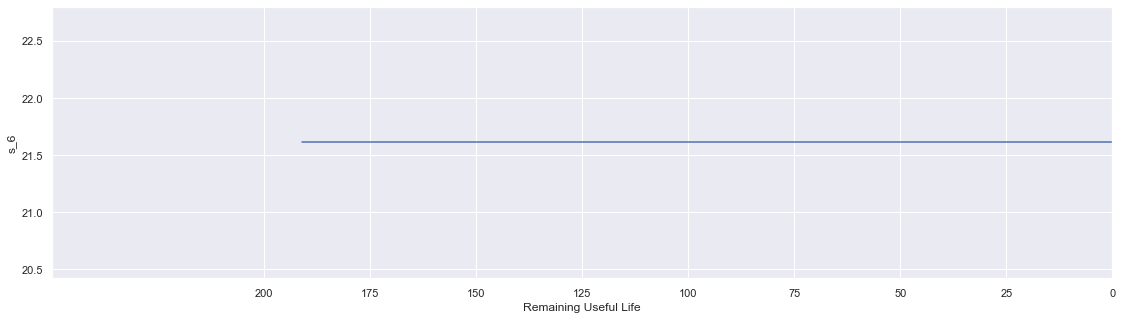

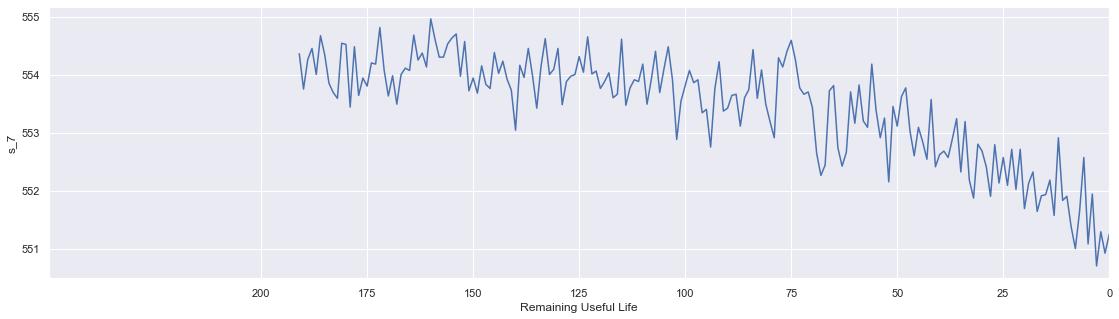

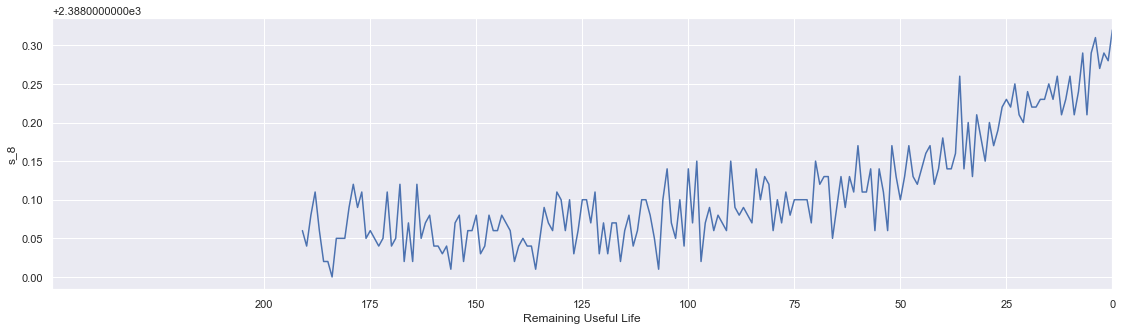

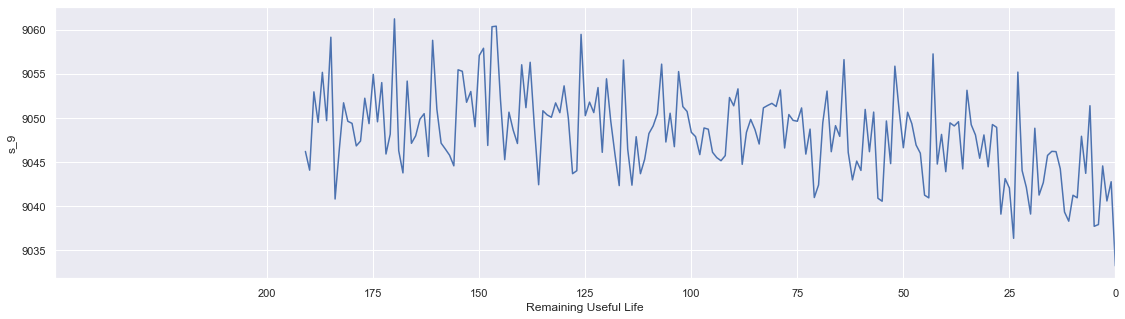

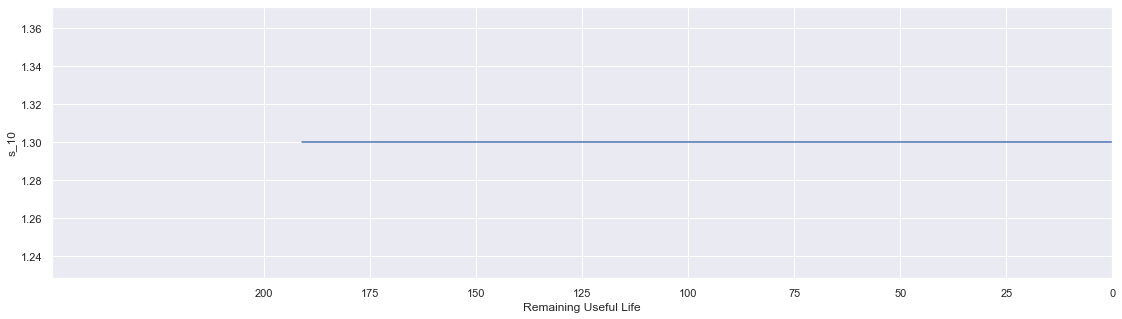

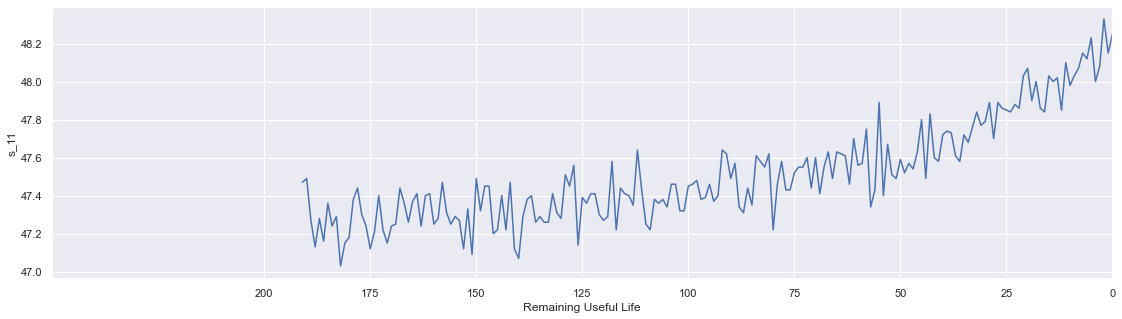

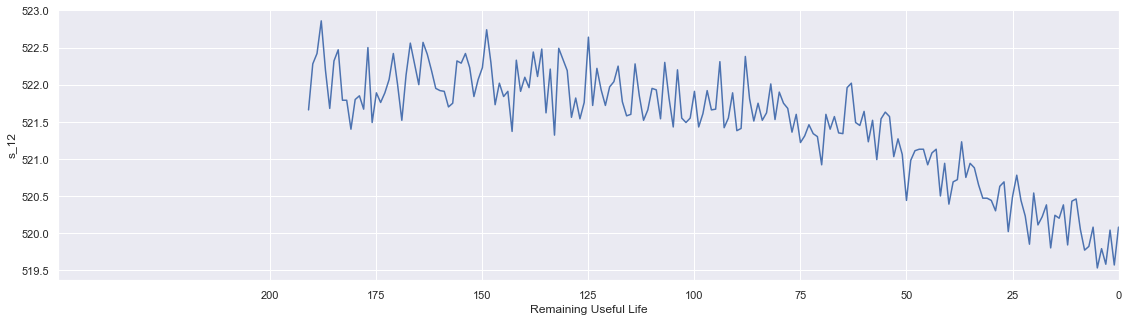

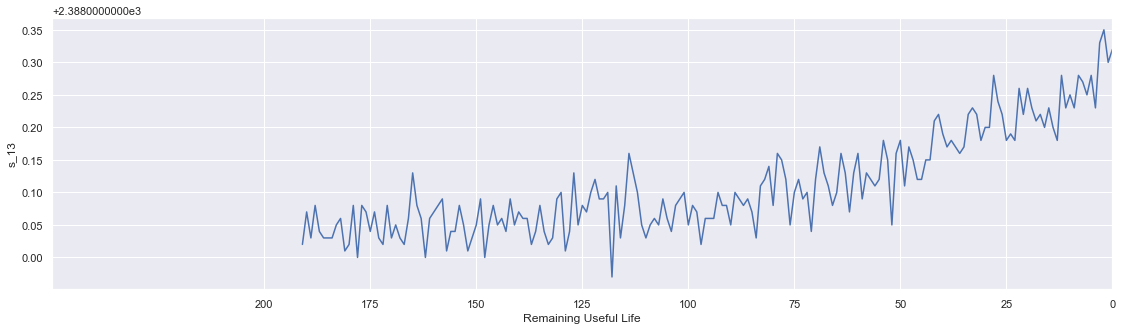

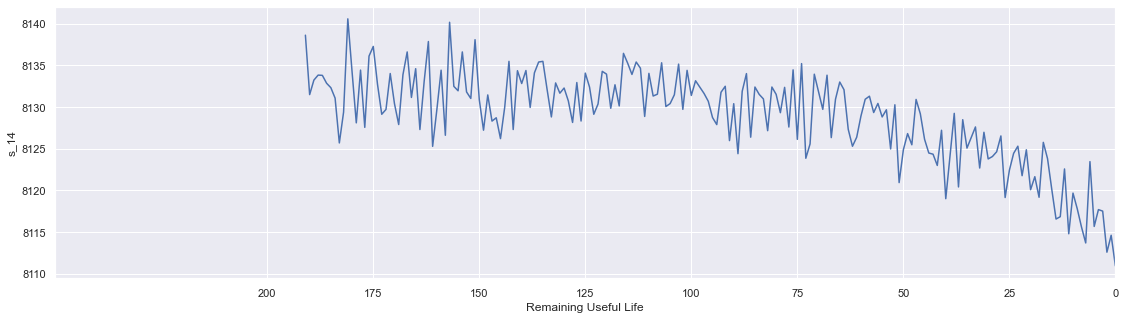

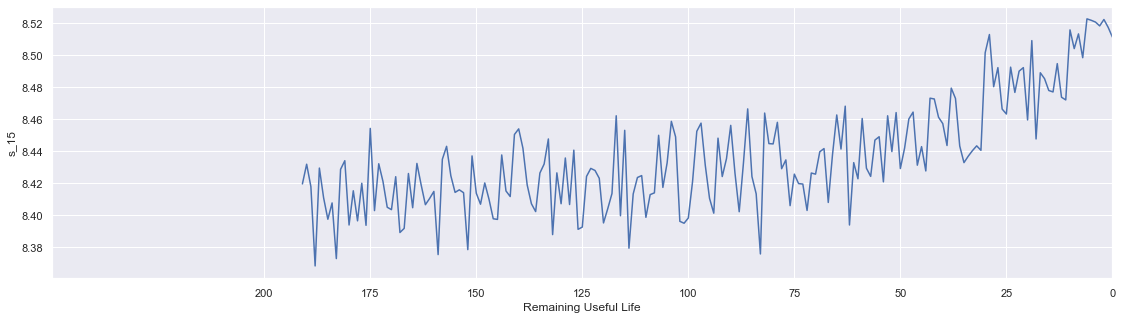

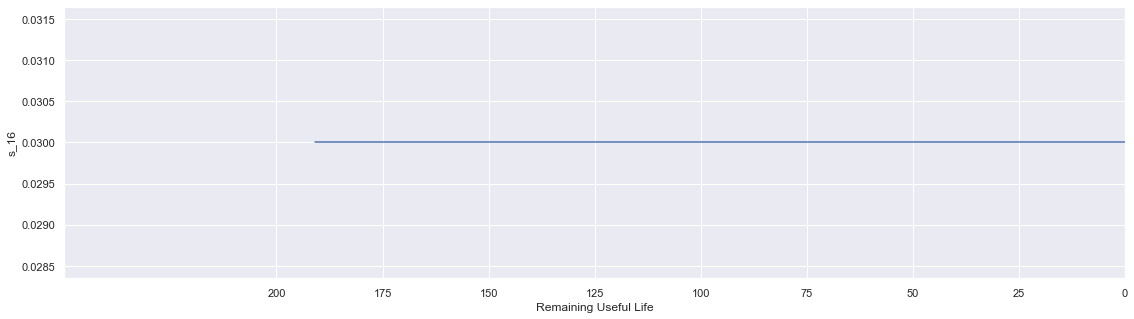

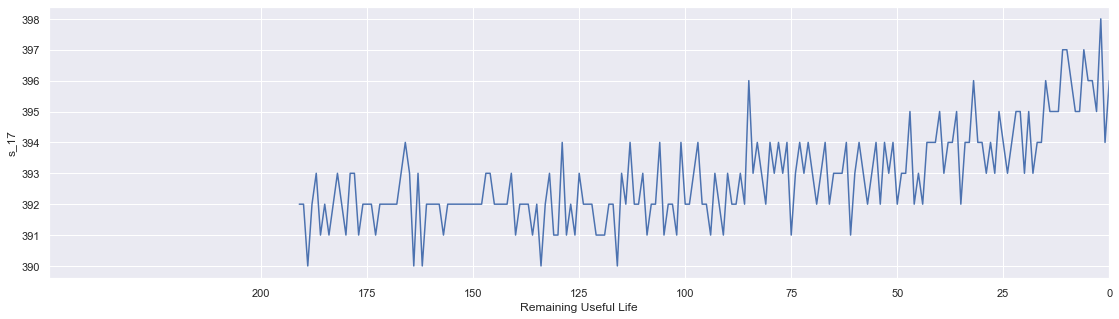

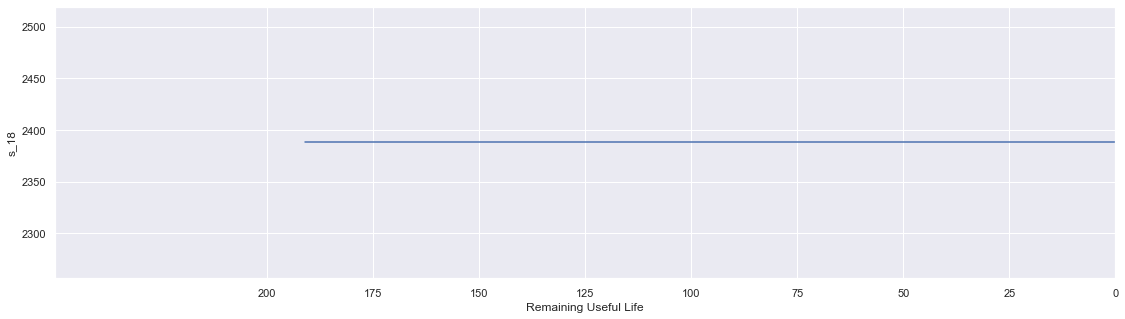

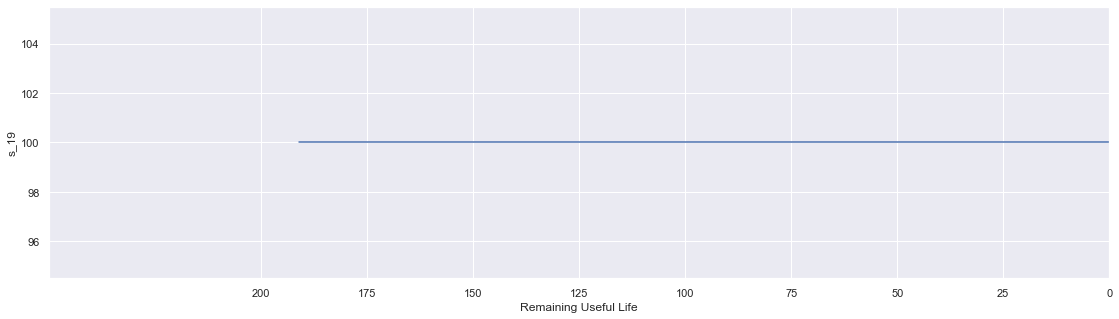

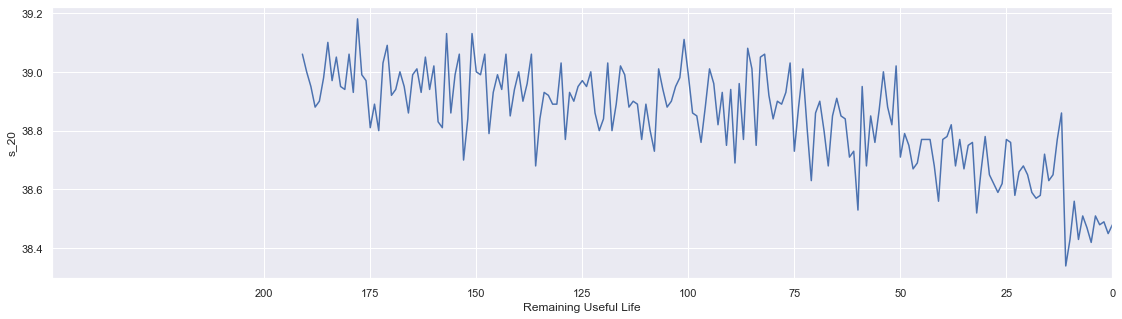

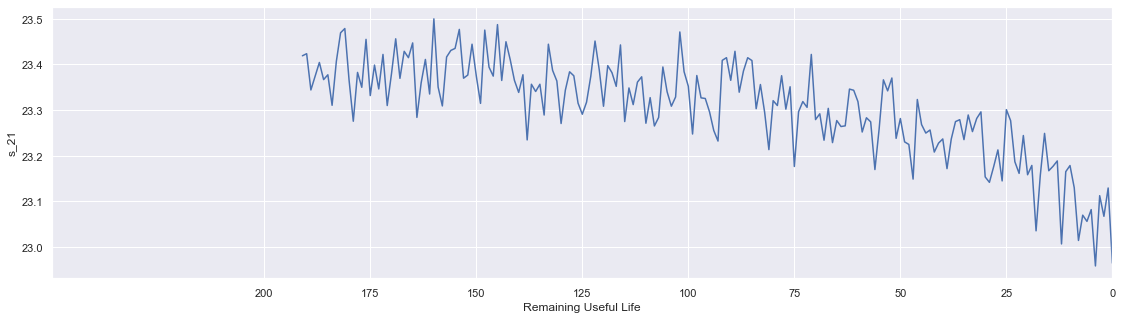

In [49]:
for sensor in sensor_names:
    plot_signal(train, sensor, 1)

> Function to display metrics

In [50]:
def evaluate(y_true, y_hat, label='Test'):
    mse = mean_squared_error(y_true, y_hat)
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    explained_variance =  explained_variance_score(y_true, y_hat)
    max_err = max_error(y_true, y_hat)
    medianae = median_absolute_error(y_true, y_hat)
    print('{} set'.format(label))
    print(f'\tR2: {variance}')
    print(f'\tMean absolute error: {mae}')
    print(f'\tMean squared error: {mse}')
    print(f'\tMedian absolute error: {medianae}')
    print(f'\tRMSE: {rmse}')
    print(f'\tExplained Variance: {explained_variance}')
    print(f'\tMax Error: {max_err}')

# Linear Regression (Basline Model)

In [ ]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train_clipped)  

# predict and evaluate
y_hat_train = lm.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'Train')

y_hat_test = lm.predict(X_test_scaled)
evaluate(y_test_clipped, y_hat_test)

Train set
	R2: 0.7340432868050608
	Mean absolute error: 17.588357088914808
	Mean squared error: 461.86388482885724
	Median absolute error: 15.521288062547683
	RMSE: 21.49101870151476
	Explained Variance: 0.7340432868050608
	Max Error: 79.75576181896031
Test set
	R2: 0.722260819654586
	Mean absolute error: 17.606226522688086
	Mean squared error: 479.6193472674128
	Median absolute error: 14.706873555820493
	RMSE: 21.900213406892018
	Explained Variance: 0.7309419253267411
	Max Error: 60.25305598699197


# Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
rf.fit(X_train_scaled, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test_scaled)
evaluate(y_test_clipped, y_hat_test)

train set
	R2: 0.9736500015836984
	Mean absolute error: 4.929420774562551
	Mean squared error: 45.75974972614028
	Median absolute error: 3.5799999999999983
	RMSE:6.764595311335356
	Explained Variance:0.9736604165329638
	Max Error:36.489999999999995
Test set
	R2: 0.8147764857288586
	Mean absolute error: 13.0934
	Mean squared error: 319.856856
	Median absolute error: 8.709999999999999
	RMSE:17.884542376029643
	Explained Variance:0.8191144907525154
	Max Error:52.18000000000001


#### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

In [ ]:
max_depth = [None] + list(range(3, 42, 3))  
min_samples_leaf = list(range(1, 102, 10))  
min_impurity_decrease = list(np.arange(0, 147)/10)  
ccp_alpha = list(np.round(np.linspace(0, 2, 81), decimals=3))  

parameters = {
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_impurity_decrease': min_impurity_decrease,
    'ccp_alpha': ccp_alpha
}

tuning_options = len(max_depth) * len(min_samples_leaf) * len(min_impurity_decrease) * len(ccp_alpha)
print(tuning_options)

1833678


In [ ]:
ITERATIONS = 300

rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42)
gkf = GroupKFold(n_splits=3)


regressor = RandomizedSearchCV(rf, 
                               parameters, 
                               cv = gkf.split(train, groups=train['engine_no']),
                               verbose=2, 
                               error_score='raise',
                               n_iter=ITERATIONS, 
                               n_jobs=-2,
                               scoring= 'neg_root_mean_squared_error')  
regressor.fit(X_train, y_train_clipped)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001FAABFED7B0>,
                   error_score='raise',
                   estimator=RandomForestRegressor(max_features='sqrt',
                                                   random_state=42),
                   n_iter=300, n_jobs=-2,
                   param_distributions={'ccp_alpha': [0.0, 0.025, 0.05, 0.075,
                                                      0.1, 0.125, 0.15, 0.175,
                                                      0.2, 0.225, 0.25, 0.275,
                                                      0.3, 0.325, 0.35, 0.375,
                                                      0.4, 0.425, 0.45, 0.475,
                                                      0.5, 0.525, 0.55, 0.575,
                                                      0.6, 0.625, 0.65, 0.675,
                                                      0.7, 0.725, ...],
                                        'max_depth': [None, 3, 6, 9, 12

In [ ]:
results = pd.DataFrame(regressor.cv_results_)
columns = ['param_min_samples_leaf', 'param_min_impurity_decrease', 'param_max_depth', 'param_ccp_alpha', 
           'mean_test_score', 'std_test_score', 'rank_test_score']
results[columns].sort_values('mean_test_score', ascending=False)

,param_min_samples_leaf,param_min_impurity_decrease,param_max_depth,param_ccp_alpha,mean_test_score,std_test_score,rank_test_score
20,41,0.1,18,0.125,-18.607610,1.824747,1
296,11,0.7,9,0.1,-18.639576,1.885600,2
4,21,0.7,24,0.6,-18.641563,1.897551,3
70,21,0.7,15,0.25,-18.641563,1.897551,3
174,51,0.0,15,0.15,-18.700893,1.807764,5
...,...,...,...,...,...,...,...
225,81,10.8,3,1.925,-20.881355,1.159106,296
97,81,11.4,3,1.45,-20.891952,1.153682,297
192,21,12.3,3,0.1,-20.907620,1.151341,298
291,41,14.2,3,0.1,-20.943283,1.145757,299


In [ ]:
print(regressor.best_params_)
print(regressor.best_score_)

{'min_samples_leaf': 41, 'min_impurity_decrease': 0.1, 'max_depth': 18, 'ccp_alpha': 0.125}
-18.60761023687854


In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42,
                           min_samples_leaf=41, min_impurity_decrease=0.1, 
                           max_depth=18, ccp_alpha=0.125)
rf.fit(X_train_scaled, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'Train')

y_hat_test = rf.predict(X_test_scaled)
evaluate(y_test_clipped, y_hat_test)

train set
	R2: 0.8266228759618548
	Mean absolute error: 13.08669346042215
	Mean squared error: 301.08896702305975
	Median absolute error: 9.881152045802104
	RMSE:17.35191537044426
	Explained Variance:0.8266233704553687
	Max Error:72.76402476969082
Test set
	R2: 0.8132076138896265
	Mean absolute error: 13.380172558035792
	Mean squared error: 322.56609308546615
	Median absolute error: 9.220863478546505
	RMSE:17.96012508546269
	Explained Variance:0.818374579250329
	Max Error:48.195246410483136


# SVR

In [ ]:
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train_clipped)  

# predict and evaluate
y_hat_train = svr.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'Train')

y_hat_test = svr.predict(X_test_scaled)
evaluate(y_test_clipped, y_hat_test)

Train set
	R2: 0.7761436785704148
	Mean absolute error: 15.632392806317506
	Mean squared error: 388.7517973016258
	Median absolute error: 12.971580414482801
	RMSE: 19.71678973113082
	Explained Variance: 0.7767763311960928
	Max Error: 73.69239261036448
Test set
	R2: 0.7546086882115255
	Mean absolute error: 15.996397285032653
	Mean squared error: 423.7587964316382
	Median absolute error: 11.25485520976661
	RMSE: 20.585402508370784
	Explained Variance: 0.7694898634421191
	Max Error: 66.24107880410885


#### Hyperparameter Tuning

In [ ]:
epsilon = [0.4, 0.3, 0.2, 0.1, 0.05]

for e in epsilon:
    svr = SVR(kernel='linear', epsilon=e)
    svr.fit(X_train_scaled, y_train_clipped)
    
    # predict and evaluate
    y_hat = svr.predict(X_train_scaled)
    mse = mean_squared_error(y_train_clipped, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_train_clipped, y_hat)
    print("epsilon:", e, "RMSE:", rmse, "R2:", variance)

epsilon: 0.4 RMSE: 21.579542484117585 R2: 0.7318477665589784
epsilon: 0.3 RMSE: 21.580777230042543 R2: 0.7318170792216312
epsilon: 0.2 RMSE: 21.57843383147433 R2: 0.7318753185838662
epsilon: 0.1 RMSE: 21.578263975067905 R2: 0.7318795396979628
epsilon: 0.05 RMSE: 21.5769459992839 R2: 0.7319122916823089


In [ ]:

svr = SVR(kernel='linear', epsilon=0.2)
svr.fit(X_train_scaled, y_train_clipped)  

# predict and evaluate
y_hat_train = svr.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_scaled)
evaluate(y_test_clipped, y_hat_test)

train set
	R2: 0.7318753185838662
	Mean absolute error: 17.5544256645076
	Mean squared error: 465.62880661931604
	Median absolute error: 15.238487834624948
	RMSE: 21.57843383147433
	Explained Variance: 0.7331234567186071
	Max Error: 72.9646128600316
Test set
	R2: 0.7302440150314189
	Mean absolute error: 17.207334034140718
	Mean squared error: 465.8334098602994
	Median absolute error: 14.681126446241578
	RMSE: 21.583174230411508
	Explained Variance: 0.7325842965250332
	Max Error: 56.9151005958646


# XGBoost

In [ ]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

In [ ]:
regressor.fit(X_train, y_train_clipped)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
y_hat_train = regressor.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = regressor.predict(X_test)
evaluate(y_test, y_hat_test)

train set
	R2: 0.8287605142186191
	Mean absolute error: 12.49285865569604
	Mean squared error: 297.3767166430354
	Median absolute error: 8.811874389648438
	RMSE: 17.244614134361935
	Explained Variance: 0.8287605143014012
	Max Error: 75.50459289550781
Test set
	R2: 0.7984193562366246
	Mean absolute error: 13.408597588539124
	Mean squared error: 348.1034856634024
	Median absolute error: 8.528350830078125
	RMSE: 18.65753160692492
	Explained Variance: 0.8037288859628284
	Max Error: 54.35106658935547


#### Hyperparameter Tuning

In [66]:
from sklearn.model_selection import RandomizedSearchCV

model = xgb.XGBRegressor()
parameters = {"max_depth": np.arange(3,50,1), "gamma": np.arange(0,20,1), "reg_lambda": np.arange(0, 1, .1)}
randomized_search = RandomizedSearchCV( 
    estimator = model,
    param_distributions = parameters,
    n_iter = 50,
    scoring = ('neg_mean_squared_error'),
    cv=3)

In [ ]:
randomized_search.fit(X_train, y_train_clipped)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          verbosity=None),
                   n_iter=50,
                   param_distributions={'gamma': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11

In [ ]:
print(randomized_search.best_params_)
print(randomized_search.best_score_)

{'reg_lambda': 0.8, 'max_depth': 3, 'gamma': 4}
-354.004460646609


In [ ]:
regressor = xgb.XGBRegressor(
    n_estimators=75,
    reg_lambda=0.7,
    gamma=4,
    max_depth=4,
)

regressor.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = regressor.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = regressor.predict(X_test)
evaluate(y_test, y_hat_test)

train set
	R2: 0.8432617607483629
	Mean absolute error: 11.901996958568006
	Mean squared error: 272.1936634437755
	Median absolute error: 8.495285034179688
	RMSE: 16.49829274330455
	Explained Variance: 0.8432617623268414
	Max Error: 77.14508056640625
Test set
	R2: 0.8163578357951778
	Mean absolute error: 13.068330626487732
	Mean squared error: 317.1260706435155
	Median absolute error: 8.56722640991211
	RMSE: 17.808033879221913
	Explained Variance: 0.8202418805470202
	Max Error: 51.901206970214844


# LSTM

In [58]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

In [52]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [53]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values
    else:
        data_matrix = df[columns].values

    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :] 

In [54]:
def gen_data_wrapper(df, sequence_length, columns, device_ids=np.array([])):
    if device_ids.size <= 0:
        device_ids = df['device_id'].unique()
        
    data_gen = (list(gen_train_data(df[df['device_id']==device_id], sequence_length, columns)) for device_id in device_ids)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [55]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[sequence_length-1:num_elements, :]

In [56]:
def gen_label_wrapper(df, sequence_length, label, device_ids=np.array([])):
    if device_ids.size <= 0:
        device_ids = df['device_id'].unique()
        
    label_gen = [gen_labels(df[df['device_id']==device_id], sequence_length, label) for device_id in device_ids]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [59]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=remaining_sensors)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=remaining_sensors)

### Hyperparameter tuning

In [60]:
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
epoch_list = list(np.arange(5,20+1,5))
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

dropouts = list(np.arange(1,5)/10)  

activation_functions = ['tanh', 'sigmoid']
batch_size_list = [32, 64, 128, 256]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list)])
tuning_options

50176

In [62]:
def create_model(input_shape, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=input_shape))
    if len(nodes_per_layer) <= 1:
        model.add(LSTM(nodes_per_layer[0], activation=activation))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(nodes_per_layer[1], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [63]:
ITERATIONS = 30

In [ ]:
%%time
results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', 'epochs', 'nodes', 'dropout', 
                                'activation', 'batch_size', 'sequence_length', 'sensor_length'])  

weights_file = 'lstm_hyper_parameter_weights.h5'


for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)
    
    mse = []
    
    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    sequence_length = random.sample(sequence_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    
    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)
    
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for train_unit, val_unit in gss.split(X_train_scaled_df['device_id'].unique(), groups=X_train_scaled_df['device_id'].unique()):
        train_unit = X_train_scaled_df['device_id'].unique()[train_unit]
        train_split_array = gen_data_wrapper(X_train_scaled_df, sequence_length, remaining_sensors, train_unit)
        train_split_label = gen_label_wrapper(X_train_scaled_df, sequence_length, ['RUL'], train_unit)
        
        val_unit = X_train_scaled_df['device_id'].unique()[val_unit]
        val_split_array = gen_data_wrapper(X_train_scaled_df, sequence_length, remaining_sensors, val_unit)
        val_split_label = gen_label_wrapper(X_train_scaled_df, sequence_length, ['RUL'], val_unit)
        
        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)
        
        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        mse.append(history.history['val_loss'][-1])
    

    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
         'sensor_length':len(remaining_sensors)}
    results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)

In [ ]:
results.sort_values('MSE')

In [ ]:
alpha = 0.1
sequence_length = 30
nodes_per_layer = [256]
dropout = 0.1
activation = 'sigmoid'
weights_file = 'lstm_model_weights.m5'
epochs = 15  
batch_size = 128

train_array = gen_data_wrapper(X_train_scaled_df, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_scaled_df, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_scaled_df[X_test_scaled_df['device_id']==device_id], sequence_length, remaining_sensors, -99.))
           for device_id in X_test_scaled_df['device_id'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

input_shape = (sequence_length, len(remaining_sensors))
final_model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.load_weights(weights_file)

final_model.fit(train_array, label_array, epochs=epochs, batch_size=batch_size)

Epoch 1/15
139/139 [==============================] - 30s 196ms/step - loss: 5509.3223
Epoch 2/15
139/139 [==============================] - 29s 208ms/step - loss: 3354.6528
Epoch 3/15
139/139 [==============================] - 28s 201ms/step - loss: 2357.4580
Epoch 4/15
139/139 [==============================] - 28s 200ms/step - loss: 1750.3843
Epoch 5/15
139/139 [==============================] - 27s 197ms/step - loss: 981.5470
Epoch 6/15
139/139 [==============================] - 30s 218ms/step - loss: 697.8623
Epoch 7/15
139/139 [==============================] - 30s 213ms/step - loss: 549.7798
Epoch 8/15
139/139 [==============================] - 27s 191ms/step - loss: 413.5298
Epoch 9/15
139/139 [==============================] - 27s 195ms/step - loss: 274.9137
Epoch 10/15
139/139 [==============================] - 29s 212ms/step - loss: 204.2335
Epoch 11/15
139/139 [==============================] - 29s 209ms/step - loss: 169.5470
Epoch 12/15
139/139 [===========================

In [ ]:
y_hat_train = final_model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = final_model.predict(test_array)
evaluate(y_test, y_hat_test)

train set
	R2: 0.9320590014558051
	Mean absolute error: 7.934723377227783
	Mean squared error: 118.70906829833984
	Median absolute error: 5.347358703613281
	RMSE: 10.895369529724121
	Explained Variance: 0.932129979133606
	Max Error: 49.972328186035156
test set
	R2: 0.8756445437531407
	Mean absolute error: 10.881597781181336
	Mean squared error: 214.74565698683142
	Median absolute error: 7.981983184814453
	RMSE: 14.654202707306577
	Explained Variance: 0.8764297069824922
	Max Error: 43.95032501220703


# Exporting Best Model

In [ ]:
import pickle
file_name = "xgb_reg.pkl"

pickle.dump(regressor, open('model/'+file_name, "wb"))